# 初期設定

In [1]:
from typing import *
import os
from glob import glob
from datetime import datetime
import math
import random as rn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nptyping import NDArray
from minepy import MINE as Mine
from crypto_data_fetcher.gmo import GmoFetcher
from scipy.stats import ttest_1samp
import talib
import shap
import numba
from rich import print as rprint

# 機械学習ライブラリ
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, KFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report, f1_score, r2_score
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, LogisticRegression, ElasticNet
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, RandomForestClassifier
import joblib
import optuna

sns.set_style('whitegrid')
colors = ['#de3838', '#007bc3', '#ffd12a']
markers = ['o', 'x', ',']
%config InlineBackend.figure_formats = ['svg']

np.random.seed(123)
rn.seed(123)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# y label 作成

### 関数定義

In [67]:
@numba.njit
def create_rough_ceeling(up_downs: NDArray[float], threshold: float = 0.002) -> Tuple[List[int], List[int]]:
    """aboutな天井と床のindexを返却"""
    start_up_idxes = []
    start_down_idxes = []
    i = 0
    while i < len(up_downs)-1:
        if up_downs[i] > threshold:
            for j in range(i+1, len(up_downs)):
                if up_downs[j] < -threshold:
                    start_up_idxes.append(i)
                    start_down_idxes.append(j)
                    i = j
                    break
            else:
                i += 1
        else:
            i += 1

    num_loop = min(len(start_up_idxes), len(start_down_idxes))
    rough_ceeling_idxes = []
    rough_floor_idxes = []
    for i in range(num_loop-1):
        rough_ceeling_idxes.append(np.argmax(up_downs[start_up_idxes[i]:start_down_idxes[i]]) + start_up_idxes[i])  # 天井は上がり始めと下がり始めの間にあるはず
        rough_floor_idxes.append(np.argmin(up_downs[start_down_idxes[i]:start_up_idxes[i+1]]) + start_down_idxes[i])  # 床は下がり始めと上がり始めの間にあるはず

    return rough_ceeling_idxes, rough_floor_idxes


def create_accurate_ceeling(close: NDArray[float], rough_floor_idxes: List[int]) -> Tuple[NDArray[float], List[int], List[int]]:
    """
    ceelingには 1: 天井, -1: 床, 0: otherwise が入る
    1. aboutな床のindex間のclose最大値を天井とし、__serch_ceelingで算出
    2. 1.で求めた天井のindex間のclose最小値を床とし、__serch_floorで算出
    """
    ceeling = np.zeros(len(close))

    def __serch_ceeling(close, floor_idxes, ceeling) -> Tuple[NDArray[float], List[int]]:
        ceeling_idxes = []
        for i in range(len(floor_idxes)-1):
            max_idx = np.argmax(close[floor_idxes[i]:floor_idxes[i+1]]) + floor_idxes[i]
            ceeling[max_idx] = 1
            ceeling_idxes.append(max_idx)
        return ceeling, ceeling_idxes

    def __serch_floor(close, ceeling_idxes, ceeling) -> Tuple[NDArray[float], List[int]]:
        floor_idxes = []
        for i in range(len(ceeling_idxes)-1):
            min_idx = np.argmin(close[ceeling_idxes[i]:ceeling_idxes[i+1]]) + ceeling_idxes[i]
            ceeling[min_idx] = -1
            floor_idxes.append(min_idx)
        return ceeling, floor_idxes

    ceeling, ceeling_idxes = __serch_ceeling(close=close, floor_idxes=rough_floor_idxes, ceeling=ceeling)
    ceeling, floor_idxes = __serch_floor(close=close, ceeling_idxes=ceeling_idxes, ceeling=ceeling)
    return ceeling, ceeling_idxes, floor_idxes


START_SPAN = 2000
END_SPAN = 2050

def show_ceeling(df):
    """天井、床の描写"""
    df = df.reset_index()[START_SPAN:END_SPAN]
    x = df['timestamp']
    y = df['close']
    x_ceeling = df[df['ceeling'] == 1.0]['timestamp']
    y_ceeling = df[df['ceeling'] == 1.0]['close']
    x_floor = df[df['ceeling'] == -1.0]['timestamp']
    y_floor = df[df['ceeling'] == -1.0]['close']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y)
    plt.scatter(x_ceeling, y_ceeling)
    plt.scatter(x_floor, y_floor)
    plt.show()


def create_ceeling_level(close, ceeling_idxes, floor_idxes):

    def __map_to_ceeling_level(x: float, ceeling: float, floor: float) -> float:
        return 2 * (x - floor) / (ceeling - floor) - 1

    num_loop = min(len(ceeling_idxes), len(floor_idxes))
    ceeling_level = [None] * len(close)
    for i in range(num_loop-1):
        c_idx = ceeling_idxes[i]
        f_idx = floor_idxes[i]
        for j in range(c_idx, f_idx+1):
            ceeling_level[j] = __map_to_ceeling_level(x=close[j], ceeling=close[c_idx], floor=close[f_idx])
        
        f_idx = floor_idxes[i]
        c_idx = ceeling_idxes[i+1]
        for j in range(f_idx, c_idx+1):
            ceeling_level[j] = __map_to_ceeling_level(x=close[j], ceeling=close[c_idx], floor=close[f_idx])

    return ceeling_level
    
def show_df(df, colum):
    """天井、床の描写"""
    df = df.reset_index()[START_SPAN:END_SPAN]
    x = df['timestamp']
    y = df[colum]
    plt.figure(figsize=(18, 6))
    plt.plot(x, y)
    plt.scatter(x, y, s=10)
    plt.show()


def diff_ceeling_level(ceeling_level):
    diff_ceeling_level = [None] * len(ceeling_level)
    for i in range(1, len(ceeling_level)-1):
        try:
            diff_ceeling_level[i] = (ceeling_level[i+1] - ceeling_level[i-1]) / 2
        except TypeError:
            continue
    return diff_ceeling_level


### 実行

,timestamp,open,high,low,close,volume
0,2020-01-01 00:00:00+00:00,7168.5,7169.0,7156.5,7159.0,4834467.0
1,2020-01-01 00:15:00+00:00,7159.0,7160.0,7158.0,7158.0,2117619.0
2,2020-01-01 00:30:00+00:00,7158.5,7161.0,7158.0,7159.0,3374198.0
3,2020-01-01 00:45:00+00:00,7159.5,7159.5,7154.5,7154.5,2530284.0
4,2020-01-01 01:00:00+00:00,7154.5,7167.0,7154.5,7166.5,3421407.0
...,...,...,...,...,...,...
69667,2021-12-26 22:45:00+00:00,51125.0,51127.5,50964.5,51011.5,11798936.0
69668,2021-12-26 23:00:00+00:00,51011.5,51081.5,50810.0,50885.0,24076253.0
69669,2021-12-26 23:15:00+00:00,50885.0,50885.5,50647.5,50715.0,33846977.0
69670,2021-12-26 23:30:00+00:00,50714.5,50825.5,50695.5,50791.0,9718853.0


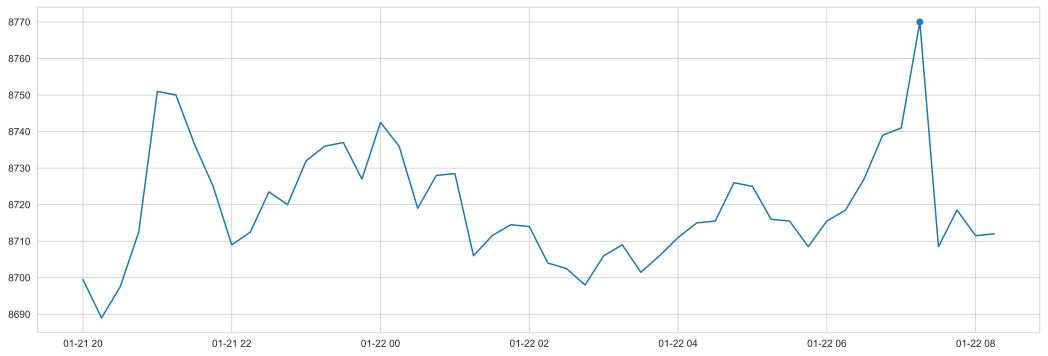

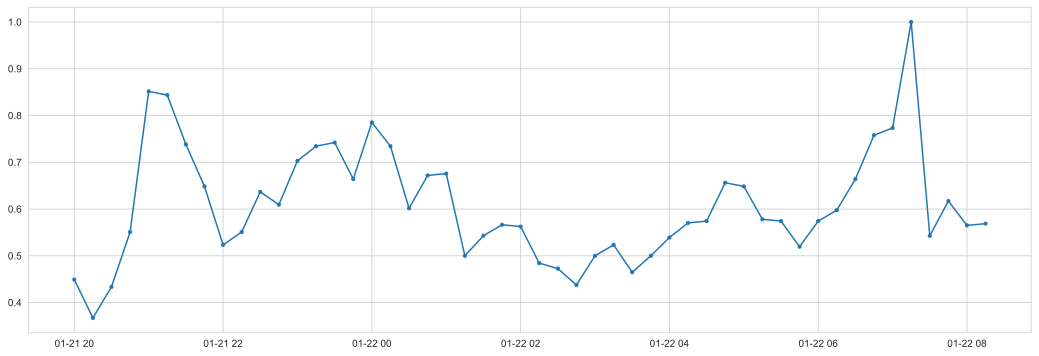

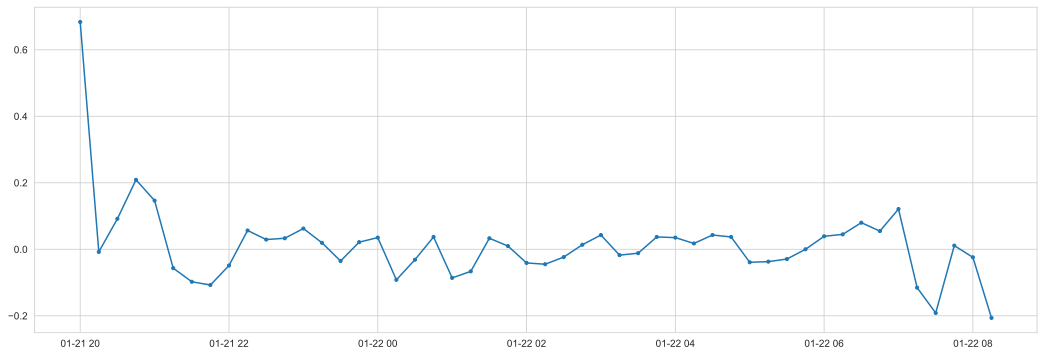

In [68]:
dtype = {
    'timestamp': str,
    'open': float,
    'high': float,
    'low': float,
    'close': float,
    'volume': float}

# BTC
df = pd.read_csv('ohlcv_15min_1226_btc.csv', dtype=dtype, parse_dates=['timestamp']).dropna()
display(df)

df['SMA'] = talib.SMA(df['close'], timeperiod=20).dropna()
df['up_down'] = np.log(df['close'] / df['SMA'])  # 0以上: 天井が近い, 0以下: 床が近い

rough_ceeling_idxes, rough_floor_idxes = create_rough_ceeling(up_downs=df['up_down'].values, threshold=0.005)
ceeling, ceeling_idxes, floor_idxes = create_accurate_ceeling(close=df['close'].values, rough_floor_idxes=rough_floor_idxes)
df['ceeling'] = ceeling

show_ceeling(df=df)

level = create_ceeling_level(close=df['close'].values, ceeling_idxes=ceeling_idxes, floor_idxes=floor_idxes)
df['ceeling_level'] = level
show_df(df=df, colum='ceeling_level')

diff_level = diff_ceeling_level(ceeling_level=df['ceeling_level'].values)
df['y_label'] = diff_level
show_df(df=df, colum='y_label')

df = df.dropna()
df[['timestamp', 'open', 'high', 'low', 'close', 'volume', 'y_label']].to_pickle('df_ceeling_y.pkl')

# print(max(df['diff_ceeling_level'].dropna()))
# print(min(df['diff_ceeling_level'].dropna()))

# 特徴量作成

In [12]:
def up_hige_size(df):
    """上ヒゲの大きさ"""
    df = df.copy()
    uphige = np.zeros(len(df))
    high = df.high.values
    close = df.close.values
    open_ = df.open.values
    # close とopenの高い方を判定
    close_or_open = df.open.values - df.close.values
    close_or_open_sign = np.sign(close_or_open)
    close_or_open_sign = np.where(close_or_open_sign == 0, 1, close_or_open_sign)
    # 陽線
    for i in range(len(close_or_open_sign)):
        sig = close_or_open_sign[i]
        h = high[i]
        o = open_[i]
        c = close[i]
        if sig == 1:
            uphige[i] = (h - o) / c
        else:
            uphige[i] = (h - c) / c
    uphige = uphige/close
    return uphige

def down_hige_size(df):
    """下ヒゲの大きさ"""
    df = df.copy()
    downhige = np.zeros(len(df))
    low = df.low.values
    close = df.close.values
    open_ = df.open.values
    # close とopenの高い方を判定
    close_or_open = df.open.values - df.close.values
    close_or_open_sign = np.sign(close_or_open)
    close_or_open_sign = np.where(close_or_open_sign == 0, 1, close_or_open_sign)
    # 陽線
    for i in range(len(close_or_open_sign)):
        sig = close_or_open_sign[i]
        l = low[i]
        o = open_[i]
        c = close[i]

        if sig == 1:
            downhige[i] = (c - l) / c
        else:
            downhige[i] = (o - l) / c
    downhige = downhige/close
    return downhige


def calc_features(df):
    open = df['open']
    high = df['high']
    low = df['low']
    close = df['close']
    volume = df['volume']

    hilo = (df['high'] + df['low']) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=20) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=20) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=20) - hilo
    df['MA'] = talib.MA(close, timeperiod=20, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=20) - hilo
    df['SMA_'] = talib.SMA(close, timeperiod=20)
    df['up_down'] = np.log(df['close'] / df['SMA_'])
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=20) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=20) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=20) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=20)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=20)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)

    df['uphige_size'] = up_hige_size(df)
    df['downhige_size'] = down_hige_size(df)

    df['pct'] = df['close'].pct_change()  # 変化率
    # 平均足を使った戦略: https://note.com/btcml/n/n6198a3714fe5
    df['heikin_cl'] = 0.25 * (df['open'] + df['high'] + df['low'] + df['close'])
    df['heikin_op'] = df['heikin_cl'].ewm(1, adjust=False).mean().shift(1)
    for span in [5, 15, 25]:
        df[f'pct_mean{span}']= df['pct'].rolling(span).mean()  # 変化率の偏差
        df[f'pct_std{span}']= df['pct'].rolling(span).std()  # 変化率の偏差
        df[f'heikin_cl_mean{span}'] = df['heikin_cl'].rolling(span).mean()
        df[f'heikin_cl_std{span}'] = df['heikin_cl'].rolling(span).std()
        df[f'heikin_op_mean{span}'] = df['heikin_op'].rolling(span).mean()
        df[f'heikin_op_std{span}'] = df['heikin_op'].rolling(span).std()

    return df


df = pd.read_pickle('df_ceeling_y.pkl')
df = calc_features(df)
df = df.set_index('timestamp')


display(df)

print('NaNが含まれている行数:', df.isnull().any(axis=1).sum())

df = df.dropna()

df.to_pickle('df_ceeling_features.pkl')

,open,high,low,close,volume,y_label,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,HT_TRENDLINE,KAMA,MA,MIDPOINT,SMA,SMA_,up_down,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,AROON_aroondown,AROON_aroonup,AROONOSC,BOP,CCI,DX,MACD_macd,MACD_macdsignal,MACD_macdhist,MFI,MINUS_DI,MINUS_DM,MOM,PLUS_DI,PLUS_DM,RSI,STOCH_slowk,STOCH_slowd,STOCHF_fastk,STOCHF_fastd,STOCHRSI_fastk,STOCHRSI_fastd,TRIX,ULTOSC,WILLR,AD,ADOSC,OBV,ATR,NATR,TRANGE,HT_DCPERIOD,HT_DCPHASE,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,uphige_size,downhige_size,pct,heikin_cl,heikin_op,pct_mean5,pct_std5,heikin_cl_mean5,heikin_cl_std5,heikin_op_mean5,heikin_op_std5,pct_mean15,pct_std15,heikin_cl_mean15,heikin_cl_std15,heikin_op_mean15,heikin_op_std15,pct_mean25,pct_std25,heikin_cl_mean25,heikin_cl_std25,heikin_op_mean25,heikin_op_std25
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-03 10:15:00+00:00,7358.5,7361.5,7314.0,7315.5,14905675.0,-0.576577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.905263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.396426e+07,NaN,1.490568e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.605744e-08,2.802872e-08,NaN,7337.375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03 10:30:00+00:00,7315.0,7325.5,7274.0,7294.5,18991477.0,-0.126126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.398058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.783631e+07,NaN,-4.085802e+06,NaN,NaN,51.5,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.973323e-07,3.852679e-07,-0.002871,7302.250,7337.375000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03 10:45:00+00:00,7294.5,7304.0,7292.0,7301.5,5442571.0,0.288288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.583333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.466148e+07,NaN,1.356769e+06,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.689384e-08,4.689384e-08,0.000960,7298.000,7319.812500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03 11:00:00+00:00,7302.0,7326.5,7297.5,7326.5,6692471.0,0.139640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.844828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.969009e+06,NaN,8.049240e+06,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,8.383385e-08,0.003424,7313.125,7308.906250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03 11:15:00+00:00,7326.5,7326.5,7313.5,7317.0,4320776.0,-0.076577,13.960836,-9.00,-31.960836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.730769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.963213e+06,NaN,3.728464e+06,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,11.480418,0.000000e+00,6.537353e-08,-0.001297,7320.875,7311.015625,NaN,NaN,7314.325,15.715886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24 00:30:00+00:00,50837.5,50871.0,50767.0,50803.5,11648209.0,0.028647,88.970256,-49.70,-188.370256,177.034439,-147.111995,-116.084360,-4.074972,11.250,-54.

NaNが含まれている行数: 63


In [13]:
features = sorted([
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
#     'MINUS_DI',
#     'MINUS_DM',
    'MOM',
#     'PLUS_DI',
#     'PLUS_DM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',
#     'STOCHRSI_fastd',
    'ULTOSC',
    'WILLR',
#     'ADOSC',
#     'NATR',
    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    # 'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    # 'LINEARREG_INTERCEPT',
    # 'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',

    'pct',
    'pct_mean5',
    'pct_mean15',
    'pct_mean25',
    'pct_std5',
    'pct_std15',
    'pct_std25',
    'uphige_size',
    'downhige_size',

    'heikin_cl',
    'heikin_op',
    'heikin_cl_mean5',
    'heikin_op_mean5',
    'heikin_cl_mean15',
    'heikin_op_mean15',
    'heikin_cl_mean25',
    'heikin_op_mean25',
    'heikin_cl_std5',
    'heikin_op_std5',
    'heikin_cl_std15',
    'heikin_op_std15',
    'heikin_cl_std25',
    'heikin_op_std25',
    'up_down',
])

print(features)
print('num of features', len(features))

['ADX', 'ADXR', 'APO', 'AROONOSC', 'AROON_aroondown', 'AROON_aroonup', 'BBANDS_lowerband', 'BBANDS_middleband', 'BBANDS_upperband', 'BETA', 'CCI', 'DEMA', 'DX', 'EMA', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR_inphase', 'HT_PHASOR_quadrature', 'HT_TRENDLINE', 'KAMA', 'LINEARREG', 'LINEARREG_ANGLE', 'MA', 'MACD_macd', 'MACD_macdhist', 'MACD_macdsignal', 'MFI', 'MIDPOINT', 'MOM', 'RSI', 'STDDEV', 'STOCHF_fastk', 'STOCH_slowd', 'STOCH_slowk', 'T3', 'TEMA', 'TRIMA', 'ULTOSC', 'WILLR', 'WMA', 'downhige_size', 'heikin_cl', 'heikin_cl_mean15', 'heikin_cl_mean25', 'heikin_cl_mean5', 'heikin_cl_std15', 'heikin_cl_std25', 'heikin_cl_std5', 'heikin_op', 'heikin_op_mean15', 'heikin_op_mean25', 'heikin_op_mean5', 'heikin_op_std15', 'heikin_op_std25', 'heikin_op_std5', 'pct', 'pct_mean15', 'pct_mean25', 'pct_mean5', 'pct_std15', 'pct_std25', 'pct_std5', 'up_down', 'uphige_size']
num of features 64


約定確率を可視化。時期によって約定確率が大きく変わると良くない。


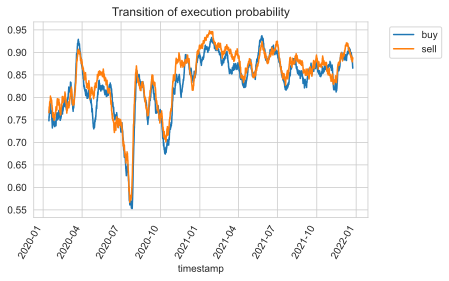

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


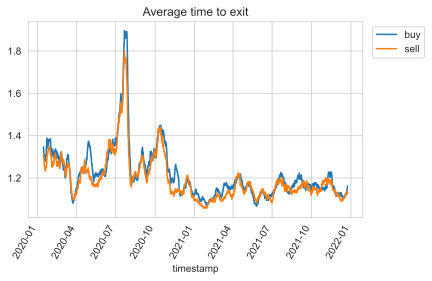

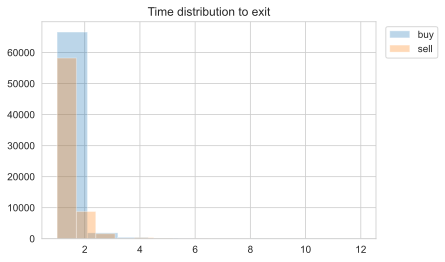

毎時刻、この執行方法でトレードした場合の累積リターン


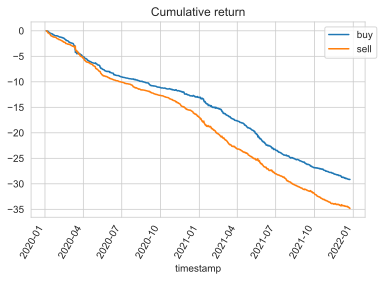

In [72]:
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time



df = pd.read_pickle('df_ceeling_features.pkl')

# 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
pips = 0.5

# ATRで指値距離を計算します
# limit_price_dist = df['ATR'] * 0.5
# limit_price_dist = df['ATR'] * 0.36
# limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

# 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
df['buy_price'] = df['close'] - pips
df['sell_price'] = df['close'] + pips

# Force Entry Priceの計算
df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['low'].values,
    pips=pips,
)

# calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['high'].values, # 売りのときは高値
    pips=pips,
)
df['sell_fep'] *= -1

horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
fee = -0.00025 # maker手数料

# 指値が約定したかどうか (0, 1)
df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['low'].shift(-1) / pips).round()).astype('float64')
df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['high'].shift(-1) / pips).round()).astype('float64')

# yを計算
df['y_buy'] = np.where(
    df['buy_executed'],
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
df['y_sell'] = np.where(
    df['sell_executed'],
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    0
)

# バックテストで利用する取引コストを計算
df['buy_cost'] = np.where(
    df['buy_executed'],
    df['buy_price'] / df['close'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    df['sell_executed'],
    -(df['sell_price'] / df['close'] - 1) + fee,
    0
)

print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
df['buy_executed'].rolling(1000).mean().plot(label='buy', rot=60)
df['sell_executed'].rolling(1000).mean().plot(label='sell', rot=60)
plt.title('Transition of execution probability')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
df['buy_fet'].rolling(1000).mean().plot(label='buy', rot=60)
df['sell_fet'].rolling(1000).mean().plot(label='sell', rot=60)
plt.title('Average time to exit')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

df['buy_fet'].hist(alpha=0.3, label='buy')
df['sell_fet'].hist(alpha=0.3, label='sell')
plt.title('Time distribution to exit')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

print('毎時刻、この執行方法でトレードした場合の累積リターン')
df['y_buy'].cumsum().plot(label='buy', rot=60)
df['y_sell'].cumsum().plot(label='sell', rot=60)
plt.title('Cumulative return')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('df_ceeling_features.pkl')

# ML

In [30]:
def show_lgb_feature_importances(lgb_model):
    ranking = np.argsort(-lgb_model.feature_importances_)  # 重要度のindexを降順で取得
    f, ax = plt.subplots(figsize=(15, 25))
    var_ = []
    for index in ranking:
        var_.append(features[index])
    # x は特徴量の重要度
    # yは特徴量の名前
    sns.barplot(x=lgb_model.feature_importances_[ranking], y =var_, orient='h')
    ax.set_xlabel("lightGBM feature importance")
    plt.tight_layout()
    plt.show()
    return var_


# p平均法 https://note.com/btcml/n/n0d9575882640
def calc_p_mean(x, n):
    ps = []
    for i in range(n):
        x2 = x[i * x.size // n:(i + 1) * x.size // n]
        if np.std(x2) == 0:
            ps.append(1)
        else:
            t, p = ttest_1samp(x2, 0)
            if t > 0:
                ps.append(p)
            else:
                ps.append(1)
    return np.mean(ps)


def calc_p_mean_type1_error_rate(p_mean, n):
    return (p_mean * n) ** n / math.factorial(n)


def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred


def show_cum_ret(df):
    # df[(df['y_pred_buy'] > 0) & (df['y_pred_sell'] < 0)]['y_buy'].cumsum().plot(label='buy', rot=60)
    df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(rot=60, title='buy', color=colors[1])
    plt.show()
    # df[(df['y_pred_buy'] < 0) & (df['y_pred_sell'] > 0)]['y_sell'].cumsum().plot(label='sell', rot=60)
    df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(rot=60, title='sell', color=colors[0])
    plt.show()
    # (df['y_buy'] * ((df['y_pred_buy'] > 0) & (df['y_pred_sell'] < 0)) + df['y_sell'] * ((df['y_pred_buy'] < 0) & (df['y_pred_sell'] > 0))).cumsum().plot(label='buy + sell', rot=60)
    (df['y_buy'] * (df['y_pred_buy'] > 0) + df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum().plot(rot=60, title='buy + sell', color=colors[2])
    plt.show()

    # df['cum_ret'] = (df['y_buy'] * ((df['y_pred_buy'] > 0) & (df['y_pred_sell'] < 0)) + df['y_sell'] * ((df['y_pred_buy'] < 0) & (df['y_pred_sell'] > 0))).cumsum()
    df['cum_ret'] = (df['y_buy'] * (df['y_pred_buy'] > 0) + df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum()
    x = df['cum_ret'].diff(1).dropna()
    p_mean_n = 5
    p_mean = calc_p_mean(x, p_mean_n)
    print('p平均法 n = {}'.format(p_mean_n))
    print('p平均 {}'.format(p_mean))
    print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))

,open,high,low,close,volume,y_label,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,HT_TRENDLINE,KAMA,MA,MIDPOINT,SMA,SMA_,up_down,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,AROON_aroondown,AROON_aroonup,AROONOSC,BOP,CCI,DX,MACD_macd,MACD_macdsignal,MACD_macdhist,MFI,MINUS_DI,MINUS_DM,MOM,PLUS_DI,PLUS_DM,RSI,STOCH_slowk,STOCH_slowd,STOCHF_fastk,STOCHF_fastd,STOCHRSI_fastk,STOCHRSI_fastd,TRIX,ULTOSC,WILLR,AD,ADOSC,OBV,ATR,NATR,TRANGE,HT_DCPERIOD,HT_DCPHASE,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,uphige_size,downhige_size,pct,heikin_cl,heikin_op,pct_mean5,pct_std5,heikin_cl_mean5,heikin_cl_std5,heikin_op_mean5,heikin_op_std5,pct_mean15,pct_std15,heikin_cl_mean15,heikin_cl_std15,heikin_op_mean15,heikin_op_std15,pct_mean25,pct_std25,heikin_cl_mean25,heikin_cl_std25,heikin_op_mean25,heikin_op_std25
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-04 02:00:00+00:00,7299.0,7299.5,7293.5,7299.5,3296054.0,-0.002347,7.614544,-0.30,-8.214544,0.483110,6.333392,4.264099,-12.807947,0.950,15.75,0.950,7297.450,0.000281,4.365256,1.018112,5.040909,3.402381,11.400743,14.763228,3.846154,0.000000,42.857143,42.857143,0.083333,-34.979663,7.971534,-4.073734,-4.419326,0.345592,61.057236,25.475446,71.994250,-20.0,21.713744,61.363584,48.208407,81.482480,62.152425,90.000000,81.482480,100.000000,96.316882,-0.009188,57.231985,-55.263158,1.435040e+07,1.405823e+06,8.418880e+07,20.218996,0.276992,6.0,25.807259,117.236100,-37.036225,21.395829,0.889128,0.305095,0,1.693994,0.799244,-3.600000,-53.704085,14.100000,-1.361538,3.957272,0.000000e+00,1.032230e-07,0.000069,7297.875,7296.522354,-0.000068,0.000955,7295.250,4.062019,7296.663592,2.972911,0.000382,0.002225,7300.475000,17.474867,7297.730743,16.144085,-0.000165,0.002073,7302.180,19.144499,7304.528132,17.065802
2020-01-04 02:15:00+00:00,7300.0,7302.5,7298.0,7298.5,1354918.0,0.002347,2.605805,-2.35,-7.305805,-3.495823,2.170688,0.898777,-16.376651,-3.750,12.00,-3.750,7296.500,0.000274,0.024074,-2.845505,1.954545,-0.247619,10.973379,14.101137,2.641026,0.000000,35.714286,35.714286,-0.333333,-28.295755,5.417653,-3.914934,-4.318448,0.403514,54.739436,25.045951,66.851803,-40.0,22.471614,59.980471,47.878667,85.777531,77.414867,84.313725,85.777531,83.186418,91.520169,-0.009090,64.698347,-66.666667,1.329657e+07,1.581562e+06,8.283389e+07,19.096210,0.261646,4.5,24.587512,118.834681,-20.952864,34.520930,0.876015,0.278410,0,1.664016,0.778212,-5.885714,-62.579077,19.171429,-1.927473,2.477902,4.693240e-08,9.386480e-09,-0.000137,7299.750,7297.198677,0.000233,0.000424,7296.025,4.551270,7295.956796,2.036174,0.000309,0.002223,7303.100000,13.533952,7299.102871,15.059601,-0.000181,0.002071,7300.730,17.801959,7303.354066,16.487472
2020-01-04 02:30:00+00:00,7298.5,7300.0,7295.0,7300.0,2895376.0,0.086854,2.819804,1.80,0.780196,-0.645283,4.690146,3.361916,-13.548390,-1.100,14.75,-1.100,7296.400,0.000493,2.377820,0.242651,5.036364,2.835714,10.744358,13.590475,2.246795,64.285714,28.571429,-35.714286,0.300000,-36.654442,7.767081,-3.626245,-4.180007,0.553762,45.070368,25.737149,65.076674,-15.5,22.027249,55.696152,48.448264,85.027652,84.095888,80.769231,85.027652,100.000000,94.395473,-0.008956,63.574833,-64.341085,1.619195e+07,2.430933e+06,8.572926e+07,18.089338,0.247799,5.0,23.415163,141.381829,-14.225246,36.845911,0.624127,-0.111154,0,1.623007,0.756415,-10.085714,-67.314759,21.014286,-2.392308,0.509902,0.000000e+00,6.567836e-08,0.000206,7298.375,7298.474338,0.000192,0.000412,7298.025,1.569733,7295.990898,2.086124,0.000066,0.001995,7304.116667,12.456125,7301.101436,12.475046,-0.000086,0.002029,7299.895,17.381694,7302.042033,15.445158
2020-01-04 02:45:00+00:00,7300.0,7317.5,7299.5,7317.0,2669077.0,0.133803,8.535168,-5.70,-19.935168,-8.450552,-4.899391,-7.658744,-23.307852,-9.750,3.75,-9.750,7298.750,0.002497,-8.223790,-6.032845,-5.672727,-6.202381,10.461162,1

69095


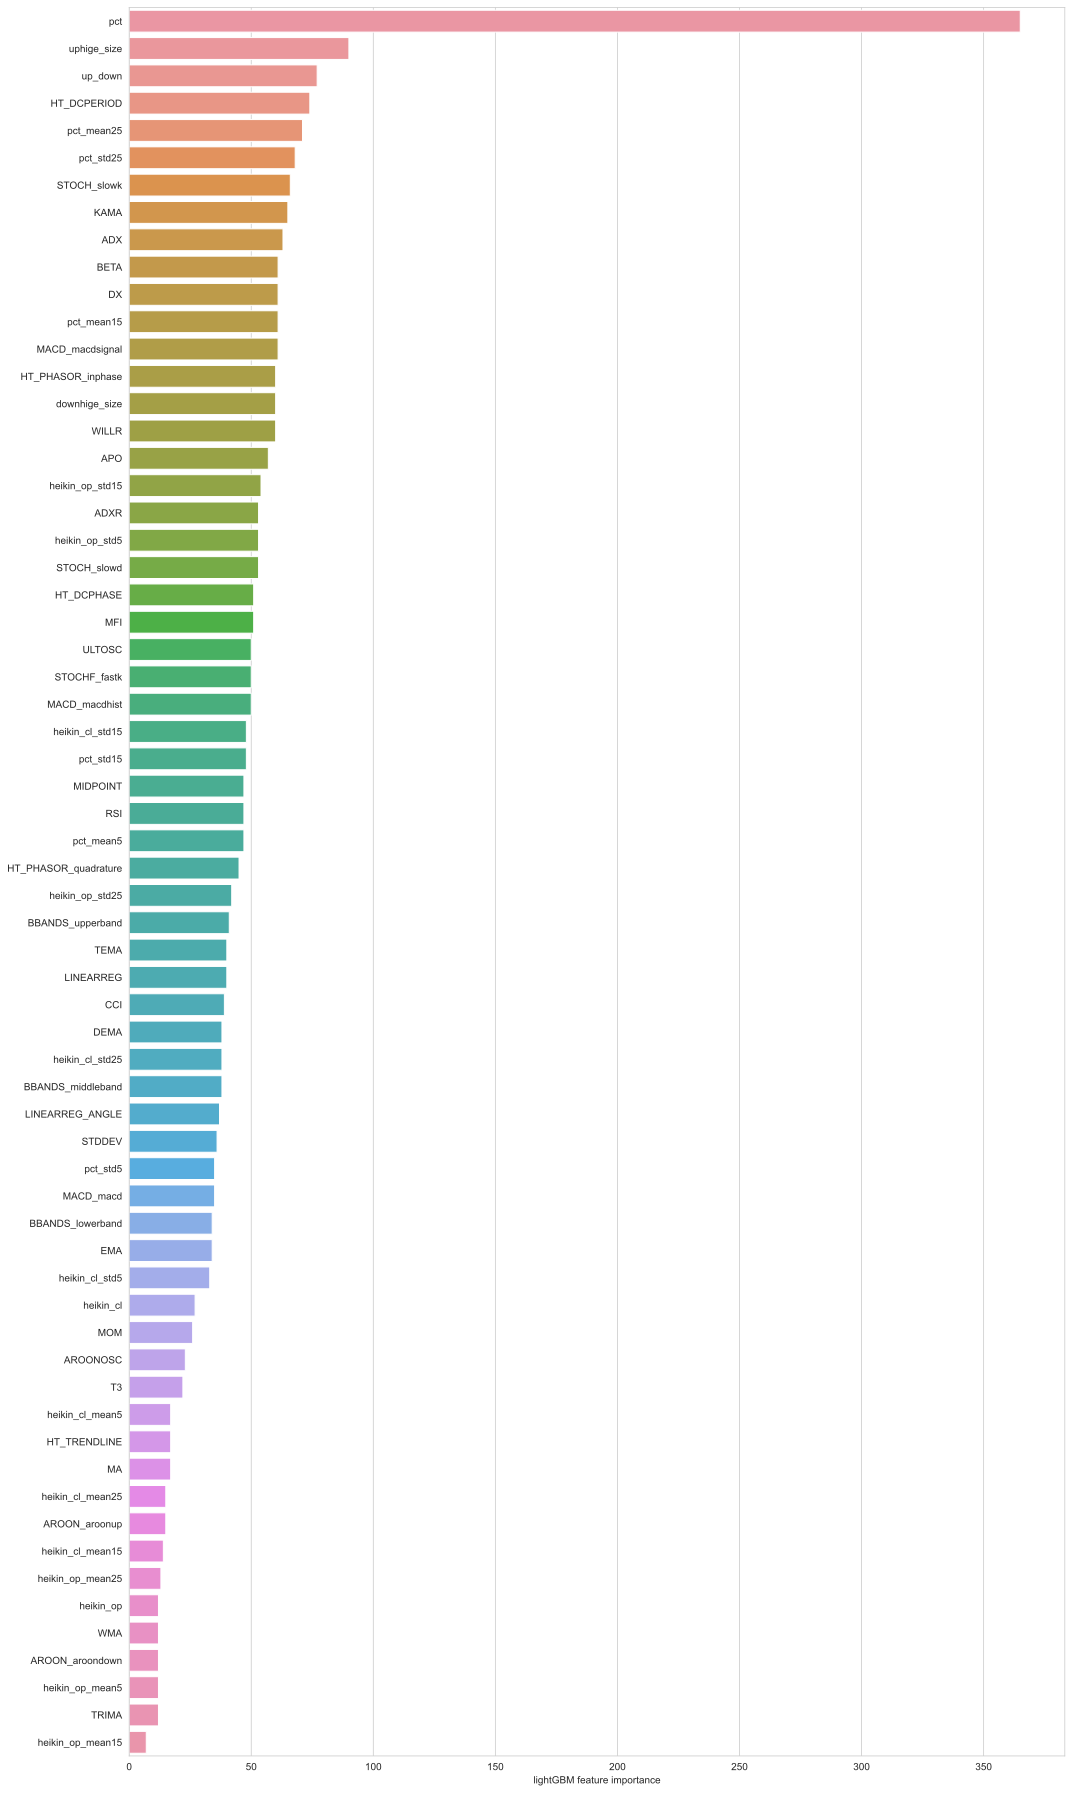

up: 0.23872727272727273
down: 0.2144856543037089


In [33]:
df = pd.read_pickle('df_ceeling_features.pkl')
display(df)
print(len(df))

# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(boosting_type='gbdt', n_jobs=-1, random_state=1)
# model = lgb.LGBMRegressor(boosting_type='dart', n_jobs=-1, random_state=1)
# model = lgb.LGBMRegressor(boosting_type='goss', n_jobs=-1, random_state=1)

# 通常のCV
cv_indicies = list(KFold().split(df))


df['y_pred'] = my_cross_val_predict(model, df[features].values, df['y_label'].values, cv=cv_indicies)

df.to_pickle('df_ceeling_pred.pkl')

_ = show_lgb_feature_importances(lgb_model=model)

threshold = 0.0
print('up:', len(df[(df['y_label'] > threshold) & (df['y_pred'] > threshold)]) / len(df[df['y_label'] > threshold]))
print('down:', len(df[(df['y_label'] < -threshold) & (df['y_pred'] < -threshold)]) / len(df[df['y_label'] < -threshold]))




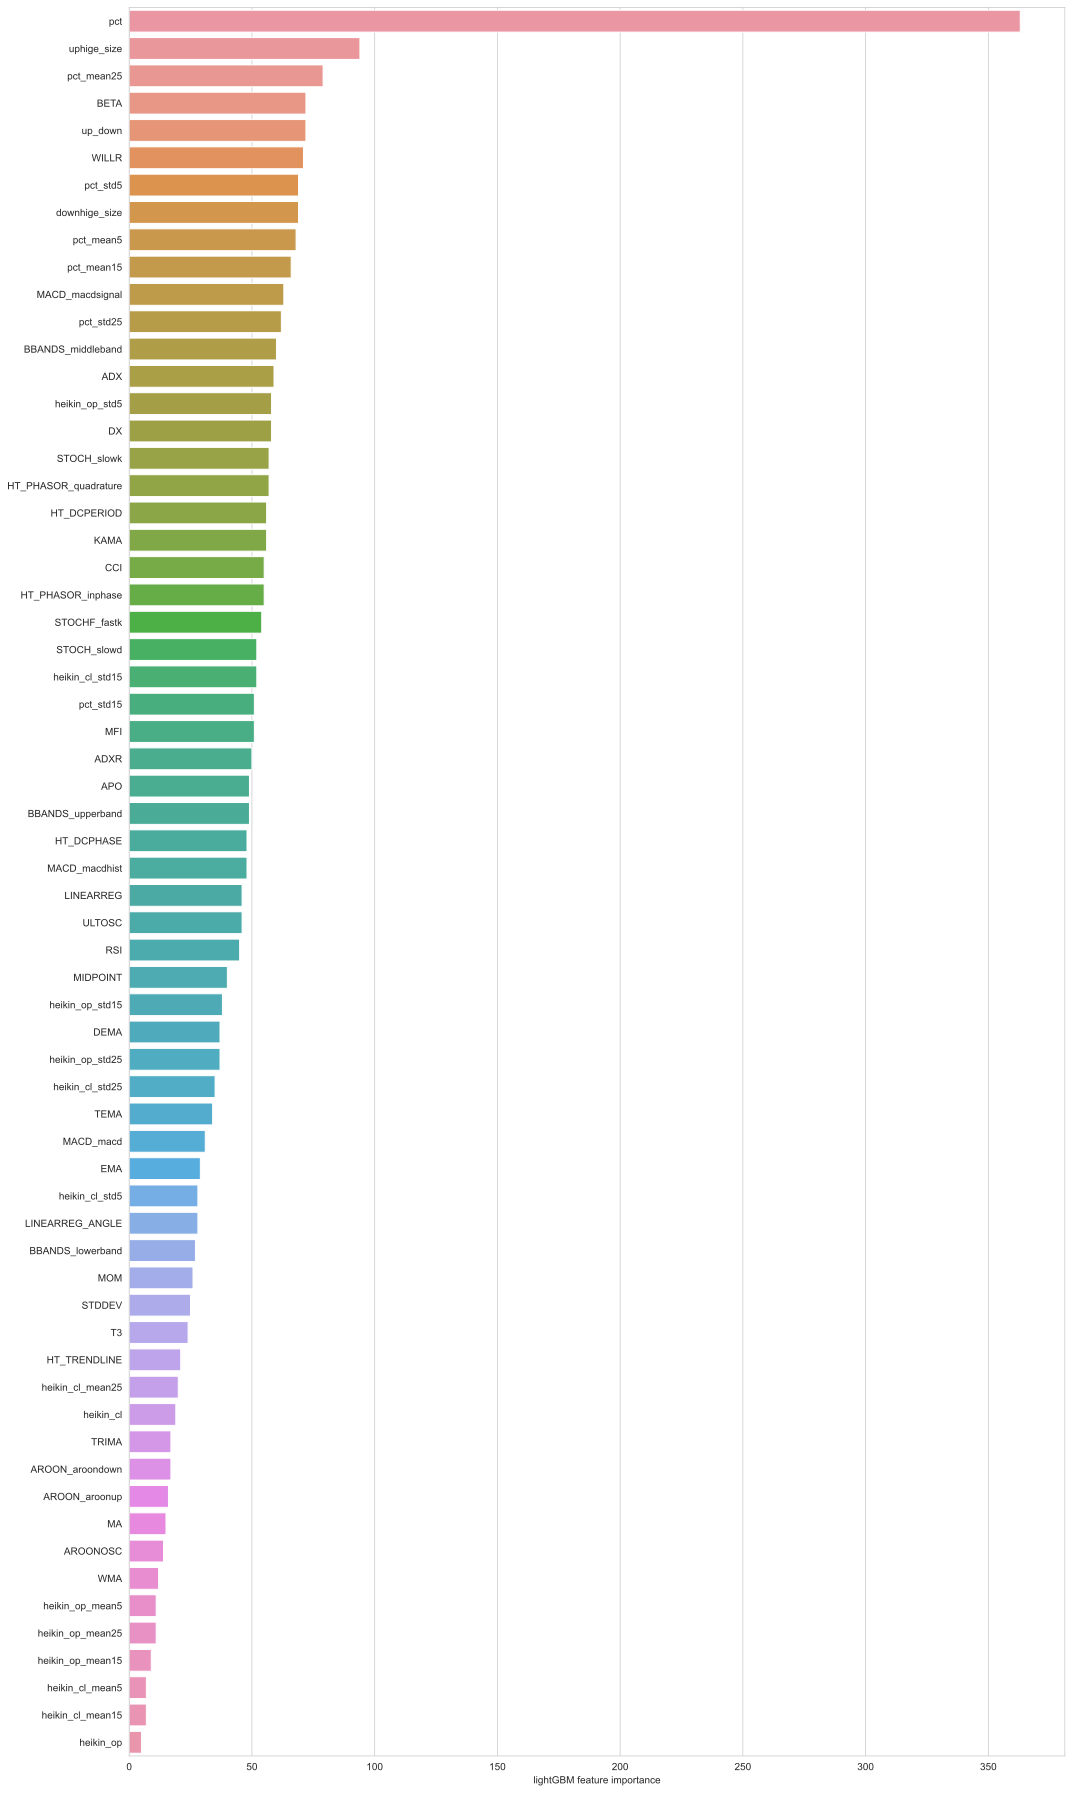

up: 0.5593744317148572
down: 0.5604969391429601


In [32]:
df = pd.read_pickle('df_ceeling_features.pkl')
df = df.reset_index()

train_ratio = 0.75
# train_ratio = 0.95
df_train = df.loc[:len(df)*train_ratio]
df_test = df.loc[len(df)*train_ratio + 50:]


# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(boosting_type='gbdt', n_jobs=-1, random_state=1)
# model = lgb.LGBMRegressor(boosting_type='dart', n_jobs=-1, random_state=1)
# model = lgb.LGBMRegressor(boosting_type='goss', n_jobs=-1, random_state=1)

def model_predict(estimator, X_train, y_train, X_test):
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    return y_pred

df = df_test.copy()

df['y_pred'] = model_predict(model, df_train[features].values, df_train['y_label'].values, df_test[features])

_ = show_lgb_feature_importances(lgb_model=model)

print('up:', len(df[(df['y_label'] > 0.05) & (df['y_pred'] > 0.05)]) / len(df[df['y_label'] > 0.05]))
print('down:', len(df[(df['y_label'] < -0.05) & (df['y_pred'] < -0.05)]) / len(df[df['y_label'] < -0.05]))

# バックテスト

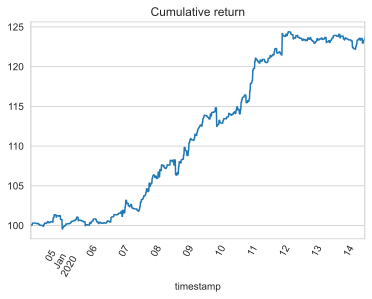

In [52]:
FEE = -0.00025
pip = 0.5

def backtest(df):
    close = df['close'].values
    high = df['high'].values
    low = df['low'].values
    y_pred = df['y_label'].values
    ret = 100.0
    order = 0
    pos = 0

    result = [0] * len(df)
    entry_price = None
    exit_price = None

    for i in range(len(df)):
        if pos > 0:
            if (high[i] > exit_price):
                ret += (exit_price / entry_price - 1) * ret - 2*FEE*ret
                pos = 0
        elif pos < 0:
            if (low[i] < exit_price):
                ret += -(exit_price / entry_price - 1) * ret - 2*FEE*ret
                pos = 0
        if order > 0:
            if (low[i] < entry_price):
                pos, order = 1, 0
        elif order < 0:
            if (high[i] > entry_price):
                pos, order = -1, 0

        if y_pred[i] > 0 and pos == 0:
            entry_price = close[i] - pip
            order = 1
        elif y_pred[i] < 0 and pos == 0:
            entry_price = close[i] + pip
            order = -1

        if pos > 0:
            exit_price = close[i] + pip
        elif pos < 0:
            exit_price = close[i] - pip
        
        result[i] = ret
    
    return result


df = pd.read_pickle('df_ceeling_pred.pkl')[:1000]

df['cum_ret'] = backtest(df=df)

df['cum_ret'].plot(rot=60)
plt.title('Cumulative return')
plt.show()